In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [61]:
spy = pd.read_csv('spy_processed.csv')

In [250]:
#spy.head()

In [226]:
cp = spy.iloc[:,[0,6,7]]
cp = cp.rename({'Close' : 'clo', 'Adj Close' : 'adc', 'Unnamed: 0.1' : 'no'}, axis =1 )

# find order of differencing -- d

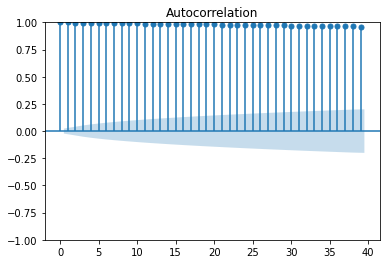

In [228]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(cp.adc.dropna());

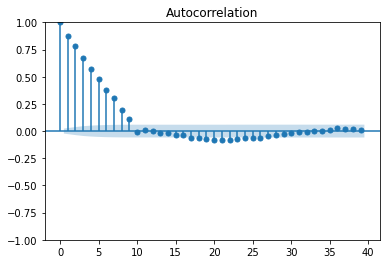

In [229]:
plot_acf(cp.adc.diff(10).dropna());

In [230]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(cp.adc)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.367720
p-value: 0.998994


In [232]:
# first differencing

result = adfuller(cp.adc.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.698999
p-value: 0.000000


In [233]:
from pmdarima.arima.utils import ndiffs

# Adf Test: 1
ndiffs(cp.adc, test='adf')

# KPSS test: 2
ndiffs(cp.adc, test='kpss')

# PP test: 1
ndiffs(cp.adc, test='pp') 

1

# Order of AR term -- p

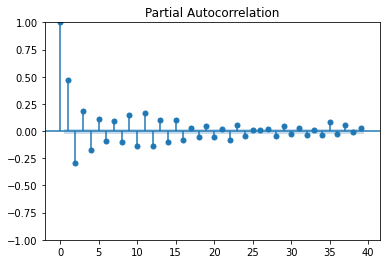

In [151]:
plot_pacf(cp.adc.diff(2).dropna(), method = 'ywm')

plt.show()

#lag : exceed significance level -- we choose 1

# Order of MA term -- q

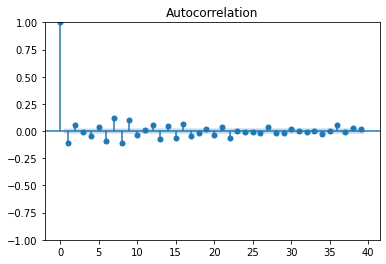

In [155]:
plot_acf(cp.adc.diff(1).dropna());
# we choose q = 2

# ARIMA Model

In [158]:
from statsmodels.tsa.arima.model import ARIMA

In [245]:
model = ARIMA(cp.adc, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    adc   No. Observations:                 7091
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14228.616
Date:                Tue, 12 Apr 2022   AIC                          28463.232
Time:                        00:50:47   BIC                          28483.831
Sample:                             0   HQIC                         28470.325
                               - 7091                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3605      0.023    -15.721      0.000      -0.405      -0.316
ma.L1          0.2529      0.024     10.405      0.000       0.205       0.301
sigma2         3.2408      0.014    234.823      0.0

<AxesSubplot:title={'center':'Density'}, ylabel='Density'>

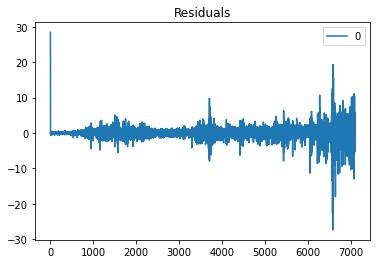

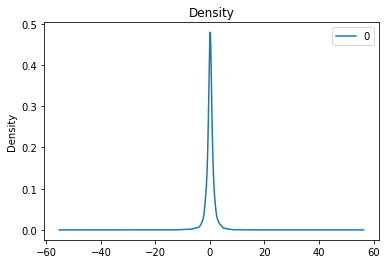

In [246]:
# residual plot

residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Residuals")
residuals.plot(kind='kde', title='Density')


# auto ARIMA

In [225]:
import pmdarima as pm

In [247]:
model = pm.auto_arima(cp.adc, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28455.982, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28547.233, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28464.158, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28471.776, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28552.967, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28454.101, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28452.098, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=28454.095, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=28452.066, Time=1.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=28235.501, Time=1.73 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=28233.818, Time=1.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28452.818, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=28447.450, Time=2.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=28447.827, Time=1.51 sec
 ARIMA(3,1,3)(0,0,0

# Predictions and prediction error

In [248]:
size = 100
train, test = cp.adc[5000:5500], cp.adc[5501:5601]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t + 5501]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

/Users/pablomjlee/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pablomjlee/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [249]:
mean_squared_error(test, predictions)

3.649191416050369